In [10]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.13.0
[]


In [1]:
import cv2
import numpy as np
import ipywidgets as widgets
from IPython.display import display, Javascript
from base64 import b64decode
import numpy as np
from IPython.display import Image
from PIL import Image as PIL_Image

In [2]:
def cv2_imshow(img):
    cv2.imshow('image', img)
    cv2.waitKey(0)  # Wait for a key press to close the window
    cv2.imwrite("photo2.jpg", img)
    cv2.destroyAllWindows()
    
def capture_image():
    cap = cv2.VideoCapture(0)  # 0 is the default camera
    success, frame = cap.read()
    if success:
        cv2.imshow('Captured Image', frame)
        cv2.waitKey(0)  # Wait for a key press to close the window
        cv2.imwrite('output.jpg', frame)  # Save the frame as JPEG file
    cap.release()
    cv2.destroyAllWindows()


In [3]:
import ipywidgets as widgets
from IPython.display import display

# fileupload widget
uploader = widgets.FileUpload(
    accept='.pb, .pbtxt',  #accepted file types
    multiple=True  # multiple files
)
display(uploader)

# handle file uploads
def handle_upload(change):
    for filename, file_info in uploader.value.items():
        print(f"Filename: {filename}")
        # access file content
        content = file_info['content']
        with open(filename, 'wb') as f:
            f.write(content)
        print(f"{filename} has been saved successfully.")

# Attach the event handler to the uploader
uploader.observe(handle_upload, names='value')


FileUpload(value=(), accept='.pb, .pbtxt', description='Upload', multiple=True)

In [4]:
pb_file = 'C:\\Users\\merva\\OneDrive\\Desktop\\uni\\AI\\deep learnning\\opencv_face_detector_uint8.pb'
pbtxt_file = 'C:\\Users\\merva\\OneDrive\\Desktop\\uni\\AI\\deep learnning\\opencv_face_detector.pbtxt'

In [6]:
# Load the OpenCV face detector model
net = cv2.dnn.readNetFromTensorflow(pb_file, pbtxt_file)

In [7]:

def take_photo(filename='photo.jpg'):
    # Start the camera
    cap = cv2.VideoCapture(0)
    
    # Check if the camera opened successfully
    if not cap.isOpened():
        print("Cannot open camera")
        return None
        

    else:
       
    
        print("Press 's' to save the photo and quit, or 'q' to quit without saving.")
    
        while True:
            # Capture frame-by-frame
            ret, frame = cap.read()
        
            # if frame is read correctly ret is True
            if not ret:
                print("Can't receive frame (stream end?). Exiting ...")
                break
        
            # Display the resulting frame
            cv2.imshow('Camera', frame)
        
            key = cv2.waitKey(1)
            if key == ord('s'):
            # Save the frame as a JPEG file
                cv2.imwrite(filename, frame)
                print(f"Photo saved as {filename}")
                break
            elif key == ord('q'):
                print("Exiting without saving.")
                break
    
        # When everything done, release the capture
        cap.release()
        cv2.destroyAllWindows()
        return filename




In [11]:
import os
path = "C:\\Users\\merva\\OneDrive\\Desktop\\uni\\AI\\archive"
path_original = os.path.join(path, "105_classes_pins_dataset")
classes = os.listdir(path_original)
all_pics = dict({})
i = 0
feature=[]
label = []
for class_no, c in enumerate(classes):
    c_path = os.path.join(path_original,c)
    pics_in_c = os.listdir(c_path)
    for p in pics_in_c:
        pic_path = os.path.join(c_path, p)
        #all_pics[c].append(pic_path)
        img_pil = PIL_Image.open(pic_path)
        frame = np.array(img_pil)
        blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), [104., 177., 123.], False, False)
        net.setInput(blob)
        detections = net.forward()
        box = detections[0, 0, i, 3:7] * np.array([frame.shape[1], frame.shape[0], frame.shape[1], frame.shape[0]])
        (startX, startY, endX, endY) = box.astype("int")
        #new_path = os.path.join(path, "cropped", c,p)
        #print(new_path)
        frame = frame[startY:endY , startX:endX]
        image = PIL_Image.fromarray(frame)
        image = image.resize((150,150))
        frame = np.array(image)
        feature.append(frame)
        label.append(class_no)

        class_dir = os.path.join(path, "cropped", c)

        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
        new_path = os.path.join(class_dir,p)
        image.save(new_path)
        





In [12]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

feature = np.array(feature)/255.0
label = np.array(label)
label = label.reshape((-1,1))
label = to_categorical(label,105)

x_train, x_val, y_train, y_val = train_test_split(feature, label, test_size=0.2, random_state=42, shuffle=True)

In [14]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from keras.regularizers import l2

local_weights_file = 'C:\\Users\\merva\\OneDrive\\Desktop\\uni\\AI\\deep learnning\\inception\\inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
     layer.trainable = False
        
# #pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='leaky_relu', activity_regularizer=l2(0.0001))(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(105, activation='softmax')(x) 
          

model = Model(pre_trained_model.input, x) 


last layer output shape:  (None, 7, 7, 768)


In [15]:
x_train.shape

(14027, 150, 150, 3)

In [16]:
y_train.shape

(14027, 105)

In [17]:
x_val.shape

(3507, 150, 150, 3)

In [18]:
y_val.shape

(3507, 105)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
callback = [EarlyStopping(monitor='val_acc', patience=3, restore_best_weights=True, verbose=1)]

In [20]:
#from keras.optimizers.legacy import Adam
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])
history=model.fit(x_train, y_train,epochs=20,callbacks=callback,  batch_size=32, validation_data=(x_val, y_val))


Epoch 1/20
439/439 [==============================] - 261s 586ms/step - loss: 3.7841 - acc: 0.1575 - val_loss: 2.9005 - val_acc: 0.3094
Epoch 2/20
439/439 [==============================] - 260s 592ms/step - loss: 2.1932 - acc: 0.4779 - val_loss: 2.1489 - val_acc: 0.4839
Epoch 3/20
439/439 [==============================] - 257s 586ms/step - loss: 1.3112 - acc: 0.6893 - val_loss: 1.8002 - val_acc: 0.5663
Epoch 4/20
439/439 [==============================] - 261s 594ms/step - loss: 0.7987 - acc: 0.8283 - val_loss: 1.6315 - val_acc: 0.6039
Epoch 5/20
439/439 [==============================] - 267s 609ms/step - loss: 0.5025 - acc: 0.9093 - val_loss: 1.5127 - val_acc: 0.6387
Epoch 6/20
439/439 [==============================] - 254s 578ms/step - loss: 0.3378 - acc: 0.9549 - val_loss: 1.3796 - val_acc: 0.6772
Epoch 7/20
439/439 [==============================] - 259s 591ms/step - loss: 0.2541 - acc: 0.9733 - val_loss: 1.3095 - val_acc: 0.6852
Epoch 8/20
439/439 [============================

In [21]:
# Function to perform face detection on a static photo
def detect_faces(net, frame):
    # Perform face detection
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), [104., 177., 123.], False, False)
    net.setInput(blob)
    detections = net.forward()

    # Process the detections
    for i in range(0, detections.shape[2]):
        # Get the confidence (probability) of the current detection:
        confidence = detections[0, 0, i, 2]
        # Only consider detections if confidence is greater than a fixed minimum confidence:
        if confidence > 0.7:
            # Get the coordinates of the current detection:
            box = detections[0, 0, i, 3:7] * np.array([frame.shape[1], frame.shape[0], frame.shape[1], frame.shape[0]])
            (startX, startY, endX, endY) = box.astype("int")
            # Draw the detection and the confidence:
            text = "{:.3f}%".format(confidence * 100)

            face = frame[startY:endY , startX:endX]
            face = np.array(PIL_Image.fromarray(face.astype('uint8'), 'RGB').resize((150,150)))
            celeb = classes[np.argmax(model.predict(np.expand_dims(face,axis=0)))]
            

            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.rectangle(frame, (startX, startY), (endX, endY), (255, 0, 0), 3)
            cv2.putText(frame, celeb, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

    # Display the result
    cv2_imshow(frame)
    


Press 's' to save the photo and quit, or 'q' to quit without saving.
Photo saved as photo.jpg
Saved to photo.jpg


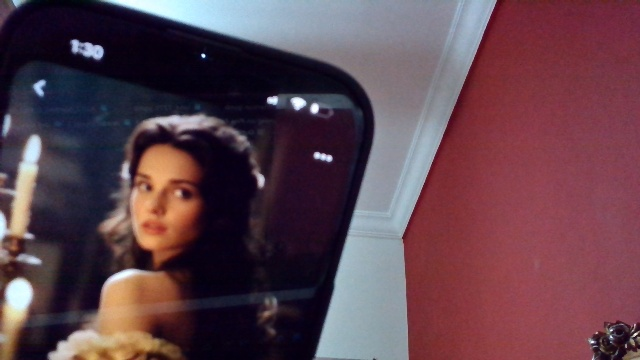

In [18]:

from io import BytesIO

try:
    # Capture the photo
    filename = take_photo()
    print('Saved to {}'.format(filename))

    # Load the image using PIL
    img_pil = PIL_Image.open(filename)

    # Convert PIL Image to NumPy array
    img_np = np.array(img_pil)

    # Show the image which was just taken.
    display(Image(filename))

except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not grant the page permission to access it.
    print(str(err))


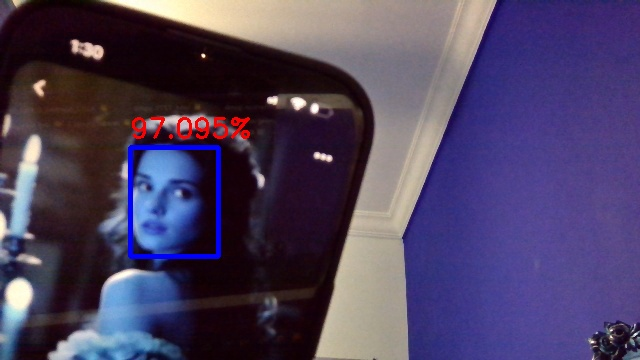

In [19]:
detect_faces(net, img_np)
display(Image("photo2.jpg"))

1/1 [==============================] - 0s 58ms/step


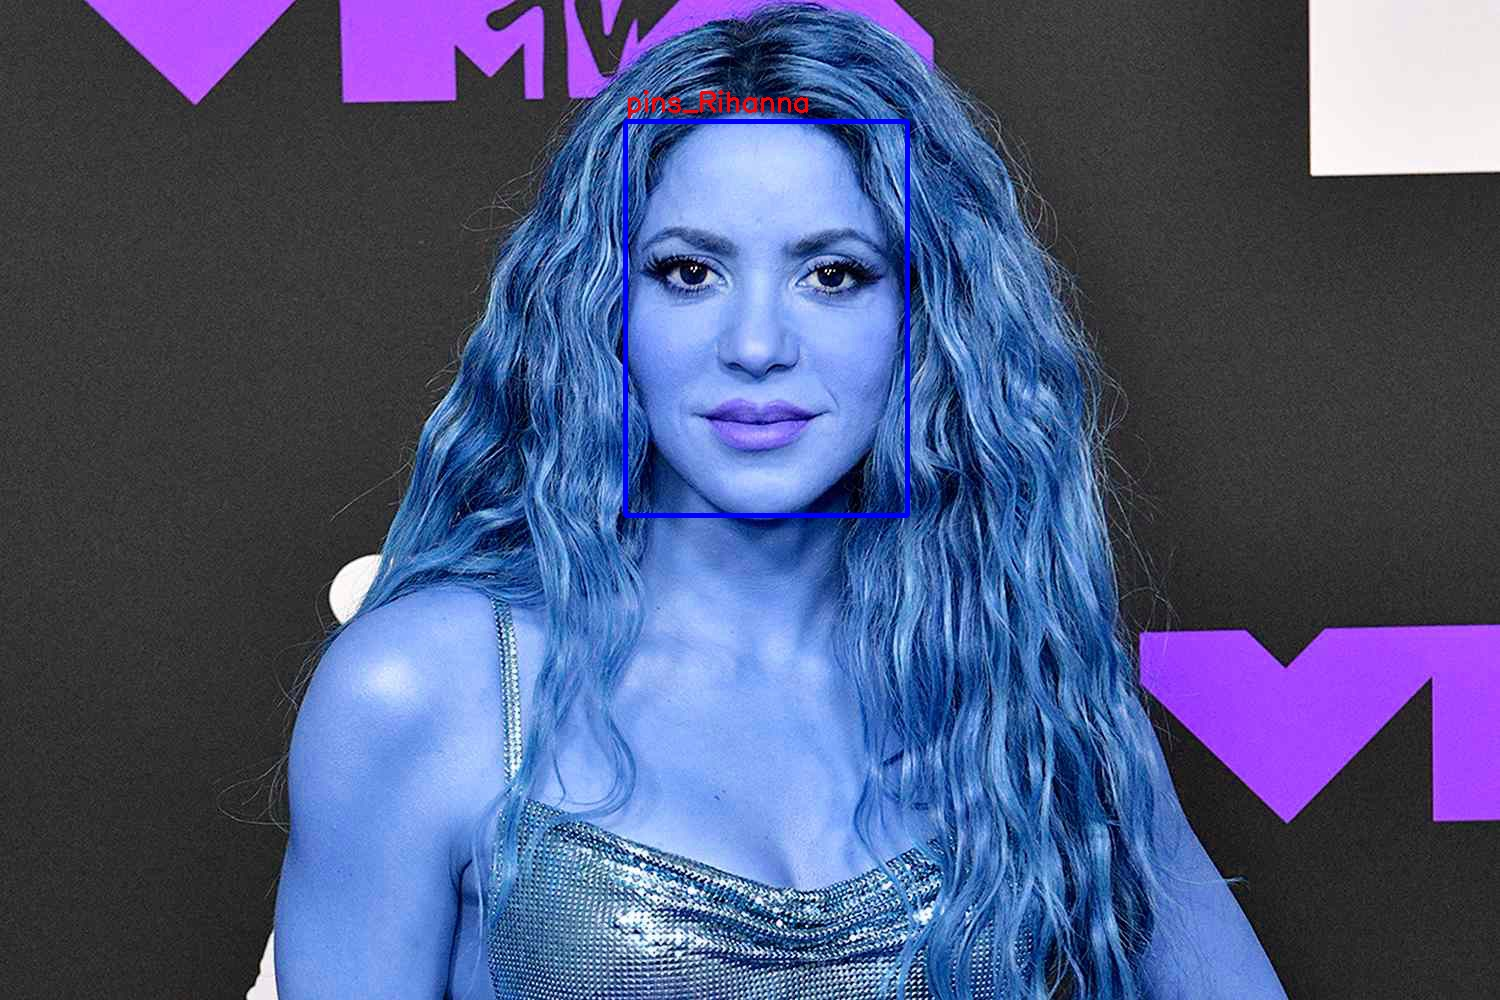

In [23]:
img_pil = PIL_Image.open("shakira.jpg")


# Convert PIL Image to NumPy array
img_np = np.array(img_pil)

detect_faces(net,img_np)
display(Image("photo2.jpg"))

In [ ]:
import cv2
import torch
import torchvision.transforms as transforms


import numpy as np

cv2.ocl.setUseOpenCL(False)

emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

# VideoCapture(0 => webcam) otherwise provide the path of the saved video
cap = cv2.VideoCapture(0)

checkpoint = torch.load("emoji_model2.pth")
model.load_state_dict(checkpoint["state_dict"])
model = model.to('cpu')

# front face detector (pretrained model) 
Classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while True:
    # ret is a bool , True if the frame reading was successful
    # frame is the picture
    ret, frame = cap.read()

    # if ret is False
    if not ret:
        # closes video
        cap.release()
        cv2.destroyAllWindows()
        break

    
    # convert frame to gray scale to match the training set
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)


    
    # detecting the frontal faces for the current frame
    bounding_boxes = Classifier.detectMultiScale(frame,scaleFactor=1.3, minNeighbors=5)
    # whenever a face is detected, calssifier determines its bounding box
    # each bounding box = [x,y,w,h] => 
    # x,y : the upper right corner coordinates of the box
    # w,h : the width and the height of the box


    # for each bounding box
    for (x, y, w, h) in bounding_boxes:
        # drawing the boundig box onto the video frame (the original one not the gray one)
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
        # rectangle takes the upper right corner : (x, y-50) and the lower left corner : (x+w, y+h+10) of the rectangle

        # cropping the image around the bounding box of the face to input only the face to the emotion detection model
        roi_gray_frame = gray_frame[y:y + h, x:x + w]

        
        # resize the cropped image to (48,48) like the training set
        cropped_img = cv2.resize(roi_gray_frame, (48, 48))
        # cv2.resize(roi_gray_frame, (48, 48)).shape = (48,48)
        # np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), 0).shape = (1,48,48)


        
        # predict
        emotion_prediction = model.predict(cropped_img)
        maxindex = int(np.argmax(emotion_prediction))

        # write the emotion predicted on the video frame
        cv2.putText(frame, emotion_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    # show the frame after editting
    cv2.imshow('Video', cv2.resize(frame,(1200,860),interpolation = cv2.INTER_CUBIC))
    # to quit video press q
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break
